In [1]:
import time, os, pickle, json
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from random import choice
from os.path import join as pjoin
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin, BaseEstimator

In [39]:
def mean_pattern(data, info):
    """
    info: label info
    """
    unique_label = np.unique(info)
    new_data = np.vstack(tuple([data[info==_, :].mean(axis=0) for _ in unique_label]))
    return new_data

def run_based_transform(data, info):
    """
    info: run info
    """
    std = StandardScaler()
    run_idxes = np.unique(info)
    new_data = np.zeros_like(data)
    for run_idx in run_idxes:
        slice = (info==run_idx)

        new_data[slice, :] = std.fit_transform(data[slice, :])

    return new_data

class SaveOut(BaseEstimator, TransformerMixin):
    def transform(self, X):
        print(X.shape)
        self.shape = shape
        self.data = X
        # what other output you want
        return self

    def fit(self, X, y=None, **fit_params):
        return self

def network_selection(network_index=None):
    """
    parameters
    ----------
    network_indx : int or list
    """
    
    main_path = '/nfs/m1/BrainImageNet/Analysis_results/'
    network_path = '/nfs/p1/atlases/ColeAnticevicNetPartition/cortex_parcel_network_assignments.mat'
    roi_path = pjoin(main_path, 'MMP_mpmLR32k.mat')
    roi = sio.loadmat(roi_path)['glasser_MMP']
    if network_index:
        network = sio.loadmat(network_path)['netassignments']
        network = [x[0] for x in network]

        # Select roi that in visual area
        if type(network_index) == int:
            select_network = [network_index]
        elif type(network_index) != list:
            raise AssertionError('Augment error: network_index should be integer or list of interger!')
        else:
            select_network = network_index
        roi_index = [idx+1 for idx,x in enumerate(network) if x in select_network]
        return np.array([True if x in roi_index else False for x in roi[0]])
    else:
        return np.array([True for x in roi[0]])

In [3]:
subjects = ['sub-core02', 'sub-core03']
data_path = '/nfs/s2/userhome/gongzhengxin/nvd/Analysis_results'


In [4]:
# let us load response data & label data
imagenet_response, imagenet_label = [], []
for sub in subjects:
    data_filepath = pjoin(data_path, 'imagenet_decoding', '_'.join([sub, 'imagenet-response.mat']))
    label_filepath = pjoin(data_path, 'imagenet_decoding', '_'.join([sub, 'imagenet-label.npy']))
    imagenet_response.append(sio.loadmat(data_filepath)['response'])
    imagenet_label.append(np.load(label_filepath))
atlas = sio.loadmat(pjoin(data_path, 'MMP_mpmLR32k.mat'))['glasser_MMP'].reshape(-1)

In [49]:
selected_super_classes = [1, 6, 8, 9, 12, 14, 16, 17, 18, 19, 20, 21, 24, 25] # label index
run_ids = np.repeat(list(range(40)), 100)
for index, sub in enumerate(subjects): 
    selected_trial_mask = np.array([True if imagenet_label[index][_] in selected_super_classes else False for _ in range(len(imagenet_label[index]))])
    selected_label = imagenet_label[index][selected_trial_mask]
    selected_runids = run_ids[selected_trial_mask]
    selected_info = np.vstack((selected_label, selected_runids)).transpose() # first column-label; second column-runid

    # selected_response = imagenet_response[index][selected_trial_mask, 0:len(atlas)]
    # print('left trials: %d' % (len(selected_response)))
    # data_filename = pjoin(data_path, 'imagenet_decoding', '_'.join([sub, '14class-cortex.npy']))
    # np.save(data_filename, selected_response)
    label_filename = pjoin(data_path, 'imagenet_decoding', '_'.join([sub, '14class-label-runidx.npy']))
    np.save(label_filename, selected_info)

In [5]:
data, data_info = [], []
for sub in subjects:
    data.append(np.load(pjoin(data_path, 'imagenet_decoding', '_'.join([sub, '14class-cortex.npy'])))) 
    data_info.append(np.load(pjoin(data_path, 'imagenet_decoding', '_'.join([sub, '14class-label-runidx.npy']))))

In [40]:
# primary visual: [1]
# secondary visual: [2]
# posterior multimodal: [10]
# ventral multimodal: [11] 
# ('preprocess', StandardScaler()),

pipe = Pipeline([('visualization', TSNE(random_state=42, n_jobs=5, perplexity=100))])
colors = ['#687980','#fbc6a4', '#f4a9a8', '#ce97b0', '#afb9c8', '#233e8b', '#1eae98', '#94d0cc', 
          '#9fe6a0', '#4aa96c', '#8e9775', '#34656d', '#00adb5', '#8ab6d6']
network_mask = network_selection()


In [6]:
# mean pattern transformation run based
mean_data, mean_data_info = [], []
for sub_idx in [0,1]:
    run_idex = np.unique(data_info[sub_idx][:,1])
    cur_data = [mean_pattern(data[sub_idx][data_info[sub_idx][:,1]==_, :], data_info[sub_idx][data_info[sub_idx][:,1]==_, 0]) for _ in run_idex]
    mean_data.append(np.vstack(tuple(cur_data)))
    new_label = np.hstack([np.unique(data_info[sub_idx][data_info[sub_idx][:,1]==_, 0]) for _ in run_idex])
    new_runidx = []
    for _ in run_idex:
        new_runidx.extend([_]*len(np.unique(data_info[sub_idx][data_info[sub_idx][:,1]==_, 0])))
    new_info = np.vstack((new_label, np.array(new_runidx))).transpose()
    mean_data_info.append(new_info)

In [33]:
# mean pattern transformation session based
ses_mean_data, ses_mean_data_info = [], []
for sub_idx in [0,1]:
    ses_idex = np.unique(np.floor(mean_data_info[sub_idx][:,1] / 10))
    cur_data = [mean_pattern(mean_data[sub_idx][np.floor(mean_data_info[sub_idx][:,1]/10)==_, :], mean_data_info[sub_idx][np.floor(mean_data_info[sub_idx][:,1]/10)==_, 0]) for _ in ses_idex]
    ses_mean_data.append(np.vstack(tuple(cur_data)))
    new_label = np.hstack([np.unique(mean_data_info[sub_idx][np.floor(mean_data_info[sub_idx][:,1]/10)==_, 0]) for _ in ses_idex])
    new_runidx = []
    for _ in ses_idex:
        new_runidx.extend([_]*len(np.unique(mean_data_info[sub_idx][np.floor(mean_data_info[sub_idx][:,1]/10)==_, 0])))
    new_info = np.vstack((new_label, np.array(new_runidx))).transpose()
    ses_mean_data_info.append(new_info)


In [44]:
draw_data, draw_data_info = ses_mean_data, ses_mean_data_info
for idx in [0,1]:
    draw_data[idx] = run_based_transform(draw_data[idx], draw_data_info[idx][:,1])

animate_dict = {1:0,  12:1, 14:1, 16:1, 17:0, 18:0, 19:0, 20:0, 21:0, 24:0, 25:0, 6:1, 8:1, 9:1}
for subid in [0,1]:
    for i in range(len(draw_data_info[subid])):
        draw_data_info[subid][i,0] = animate_dict[draw_data_info[subid][i,0]]

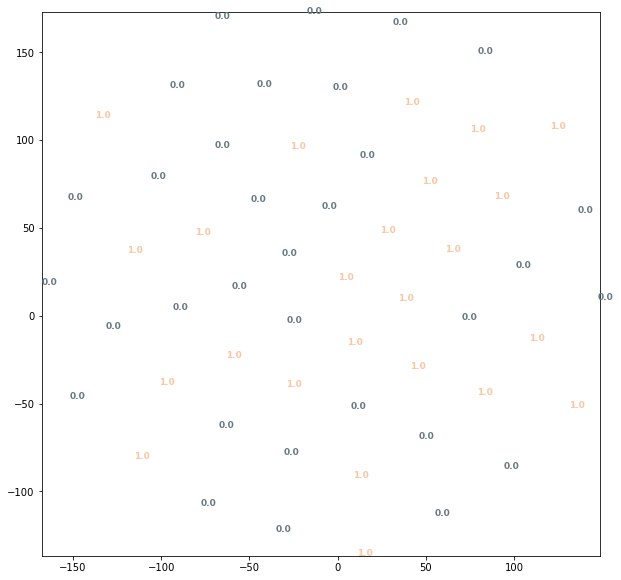

In [45]:
index = 0 
X_embedded = pipe.fit_transform(draw_data[index][:, network_mask])
unique_label = np.unique(draw_data_info[0][:,0])
plt.figure(figsize=(10, 10))
plt.xlim(X_embedded[:, 0].min(), X_embedded[:, 0].max() + 1)
plt.ylim(X_embedded[:, 1].min(), X_embedded[:, 1].max() + 1)
for i in range(len(draw_data_info[0])):
    # actually plot the digits as text instead of using scatter
    plt.text(X_embedded[i, 0], X_embedded[i, 1], str(draw_data_info[0][i,0]),
    color = colors[np.where(unique_label==draw_data_info[0][i,0])[0][-1]],
    fontdict={'weight': 'bold', 'size': 9})

In [105]:
network_mask == network_selection([1])

array([ True,  True,  True, ...,  True,  True,  True])

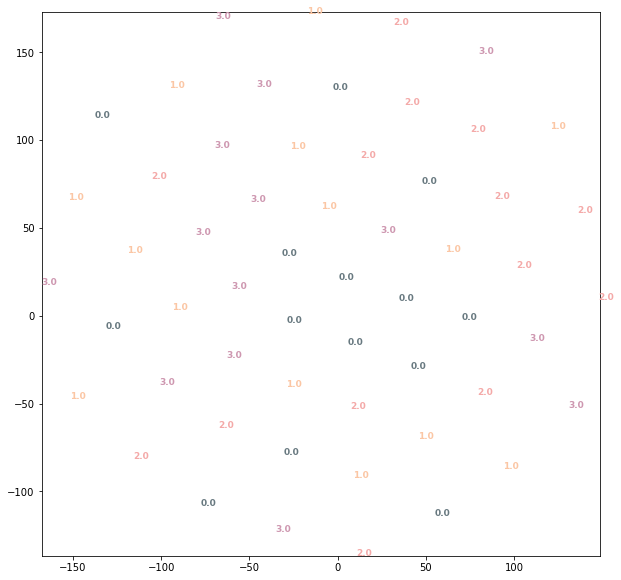

In [43]:
index = 0 
X_embedded = pipe.fit_transform(draw_data[index][:, network_mask])
unique_runidx = np.unique((draw_data_info[0][:,1]))
plt.figure(figsize=(10, 10))
plt.xlim(X_embedded[:, 0].min(), X_embedded[:, 0].max() + 1)
plt.ylim(X_embedded[:, 1].min(), X_embedded[:, 1].max() + 1)
for i in range(len(draw_data_info[index])):
    # actually plot the digits as text instead of using scatter
    plt.text(X_embedded[i, 0], X_embedded[i, 1], str(draw_data_info[index][i,1]),
    color = colors[np.where(unique_runidx==draw_data_info[index][i,1])[0][-1]%14],
    fontdict={'weight': 'bold', 'size': 9})
plt.show()


In [13]:
import pickle
# with open(pjoin(data_path, 'imagenet_decoding', 'mean_pattern_response.pkl'), 'wb') as f:
#     pickle.dump(mean_data, f)
with open(pjoin(data_path, 'imagenet_decoding', 'mean_pattern_label_rundix.pkl'), 'rb') as f:
    a = pickle.load(f)

0.8414709848078965

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScale, MinMaxScale, Normalizer
class fmriFold(TransformerMixin, BaseEstimator):
    def __init__(self, roi_index=None, roi_network=None, standard_metirc=None):
        self.roi_index = roi_index
        self.roi_network = roi_network
        self.standard_metric = standard_metric

    def set_standardization(self, standard_metirc=None):
        if standard_metirc:
            if standard_metirc=='Standard':
                self.standard = StandardScaler
            if standard_metirc=='MinMax':
                self.standard = MinMaxScale
            if standard_metric=='Robust':
                self.standard = RobustScale
            if standard_metric=='Normal':
                self.standard = Normalizer
        else:
            self.standard = None
        

    def run_based_transform(self, data, info):
        """
        info: run info
        """
        if self.standard:
            standard_propcessor = self.standard
            run_idxes = np.unique(info)
            new_data = np.zeros_like(data)
            for run_idx in run_idxes:
                slice = (info==run_idx)

                new_data[slice, :] = standard_propcessor.fit_transform(data[slice, :])

            return new_data
        else:
            return data

    def network_selection(self, network_index=None):
        """
        parameters
        ----------
        network_indx : int or list
        """
        
        main_path = '/nfs/m1/BrainImageNet/Analysis_results/'
        network_path = '/nfs/p1/atlases/ColeAnticevicNetPartition/cortex_parcel_network_assignments.mat'
        roi_path = pjoin(main_path, 'MMP_mpmLR32k.mat')
        roi = sio.loadmat(roi_path)['glasser_MMP']
        if network_index:
            network = sio.loadmat(network_path)['netassignments']
            network = [x[0] for x in network]

            # Select roi that in visual area
            if type(network_index) == int:
                select_network = [network_index]
            elif type(network_index) != list:
                raise AssertionError('Augment error: network_index should be integer or list of interger!')
            else:
                select_network = network_index
            roi_index = [idx+1 for idx,x in enumerate(network) if x in select_network]
            return np.array([True if x in roi_index else False for x in roi[0]])
        else:
            return np.array([True for x in roi[0]])